In [2]:
# Average pooling: Nadaraya-Watson kernel regression
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
# generate dataset
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

In [4]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)

In [5]:
y_truth = f(x_test)
n_test = len(x_test)

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

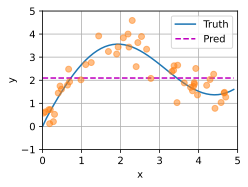

In [7]:
# first try the easiest predictor what is based on the average pooling to output the mean of teh samples
y_hat = torch.repeat_interleave(y_train.mean(), n_test)  # repeat input value for n_test times
plot_kernel_reg(y_hat)

# Non-parameter Attention Pooling
Obviously, average pooling overlooked input $x_i$. So Nadaraya and Watson proposed a better idea, which used the position of inputs to execute weighting on output $y_i$
$$
f(x) = \sum_{i=1}^n\frac{K(x-x_i)}{\sum_{j=1}^nK(x-x_i)}y_i
$$
where the K is kernel. This formular describe a predictor called Nadaraya-Watson kernel regression. Based on this, we will rewrite our attention pooling to make it more universal
$$
f(x) = \sum_{i=1}^n\alpha(x, x_i)y_i
$$
where the x is query, $(x_i, y_i)$ is the key-value pairs. Compared to the pooling above, attention is the average of y_i. We model the relation between query $x$ and key $x_i$ as attention weight $\alpha(x, x_i)$. This weight will be given out to $y_i$. To any query, attention weight of the model is an effective probability distribution: they are non-negative elements, and sum is 1
To better understand the process of pooling, we could consider a Gaussian kernel, which is defined as:
$$
K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})
$$
Put the kernel into the formular of pooling
\begin{equation}
f(x) &= \sum_{i=1}^n\alpha(x, x_i)y_i \\
&= \sum_{i=1}^n\frac{exp(-\frac{1}{2}(x-x_i)^2)}{\sum_{j=1}^nexp(-\frac{1}{2}(x-x_j)^2)}y_i \\
&= \sum_{i=1}^nsoftmax(-\frac{1}{2}(x-x_i)^2)y_i
\end{equation}
which means that if the key $x_i$ closer to the given query $x$, the bigger the value of its pair $y_i's$ attention weights, which means that it gains more attention.

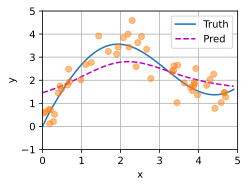

In [8]:
# shape of X_repeat: (n_test, n_train)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train) ** 2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

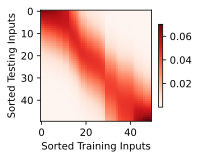

In [9]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted Training Inputs',
                  ylabel='Sorted Testing Inputs')

## Parameter Nadaraya-Watson Kernel Regression
We could integrate learnable parameters into the attention pooling
\begin{equation}
f(x) &= \sum_{i=1}^n\alpha(x, x_i)y_i \\
&= \sum_{i=1}^n\frac{exp(-\frac{1}{2}((x-x_i)w)^2)}{\sum_{j=1}^nexp(-\frac{1}{2}((x-x_j)w)^2)}y_i \\
&= \sum_{i=1}^nsoftmax(-\frac{1}{2}((x-x_i)w)^2)y_i
\end{equation}

In [11]:
# to better compute attention in small batches, we could use the batch matrix multiply in Pytorch
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape, torch.matmul(X, Y).shape, torch.bmm(X, Y), torch.matmul(X, Y)
# bmm will only compute the latter 2 dimensions, but when both of the X and Y are 3-D tensors, they are the same

(torch.Size([2, 1, 6]),
 torch.Size([2, 1, 6]),
 tensor([[[4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.]]]),
 tensor([[[4., 4., 4., 4., 4., 4.]],
 
         [[4., 4., 4., 4., 4., 4.]]]))

In [12]:
weights = torch.ones((2, 10)) * 0.1

values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [13]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w) ** 2 / 2, dim=1
        )
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [14]:
# X_tile: (n_train, n_train), each row contains the same training input
X_tile = x_train.repeat((n_train, 1))
# Y_tile: (n_train, n_train), each row contains the same training output
Y_tile = y_train.repeat((n_train, 1))
# keys: (n_train, n_train-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values: (n_train, n_train-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

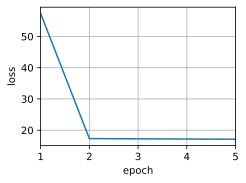

In [15]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

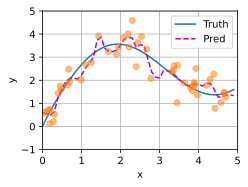

In [16]:
keys = x_train.repeat((n_test, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

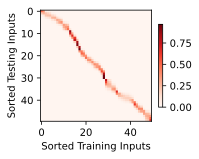

In [17]:
# compared to the non-parameter model,model with learnable parameters become unsmooth where the attention weights are bigger
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted Training Inputs',
                  ylabel='Sorted Testing Inputs')